In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
from scip_workflows.common import *


In [122]:
from sklearn.preprocessing import LabelEncoder

In [123]:
try:
    features = snakemake.input.features
    index = snakemake.input.index
    columns = snakemake.input.columns
    labels = snakemake.input.labels
except NameError:
    data_root = Path("/home/maximl/scratch/data/vsc/datasets/wbc/")
    # data_root = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc"
    data_scip = data_root / "scip/20220713131400/"
    features = data_scip / "WBC_features.parquet"
    index = data_scip / "indices/index.npy"
    columns = data_scip / "indices/columns.npy"
    labels = data_scip / "labels.parquet"

In [124]:
df = pq.read_table(features).to_pandas()

df = df[numpy.load(columns, allow_pickle=True)]
df = df.loc[numpy.load(index, allow_pickle=True)]

labels = pq.read_table(labels).to_pandas()
df = df.merge(labels, left_index=True, right_index=True)

df.shape


(218404, 3923)

In [125]:
df = df.loc[df["meta_label"] != "unknown"].copy()
df["meta_label"] = df["meta_label"].cat.remove_unused_categories()
enc = LabelEncoder().fit(df["meta_label"])

In [126]:
import scanpy
import anndata

In [14]:
adata = anndata.AnnData(
    X = df.reset_index().filter(regex=".*_li_.*(BF1|BF2|SSC)$"),
    obs = df.filter(regex="meta").reset_index()
)

/tmp/ipykernel_115744/1526833089.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
scanpy.pp.scale(adata)

/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


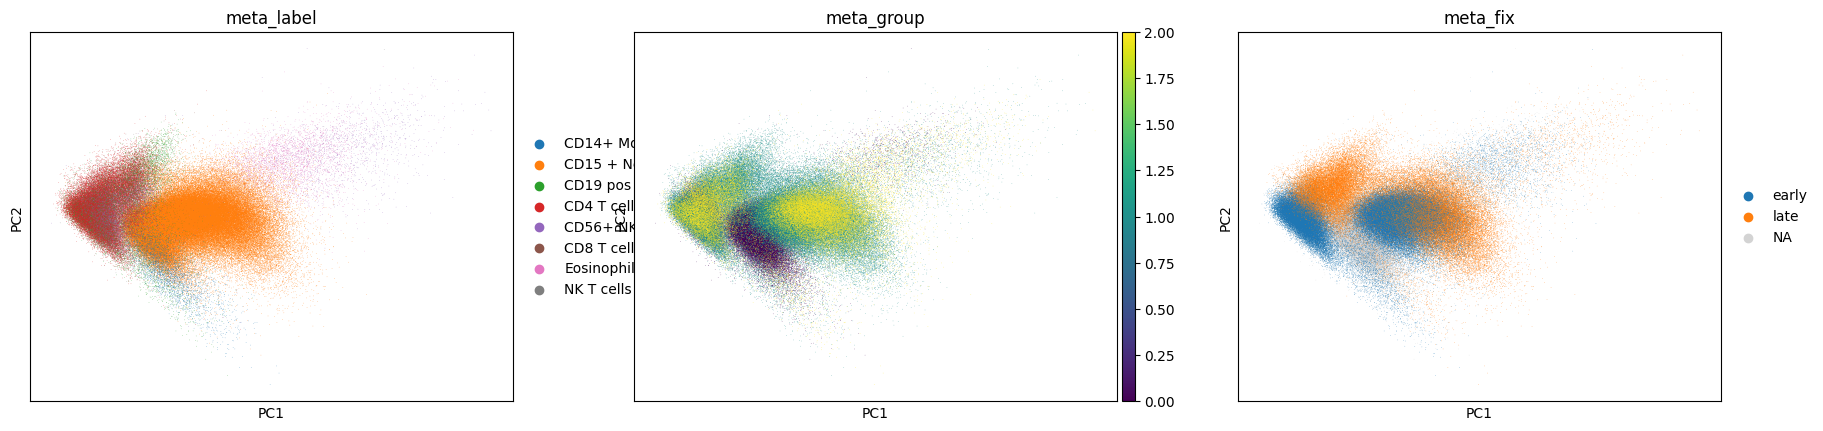

In [17]:
scanpy.pp.pca(adata)
scanpy.pl.pca(adata, color=["meta_label", "meta_group", "meta_fix"])

In [ ]:
scanpy.pp.neighbors(adata)
scanpy.tl.umap(adata)

/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


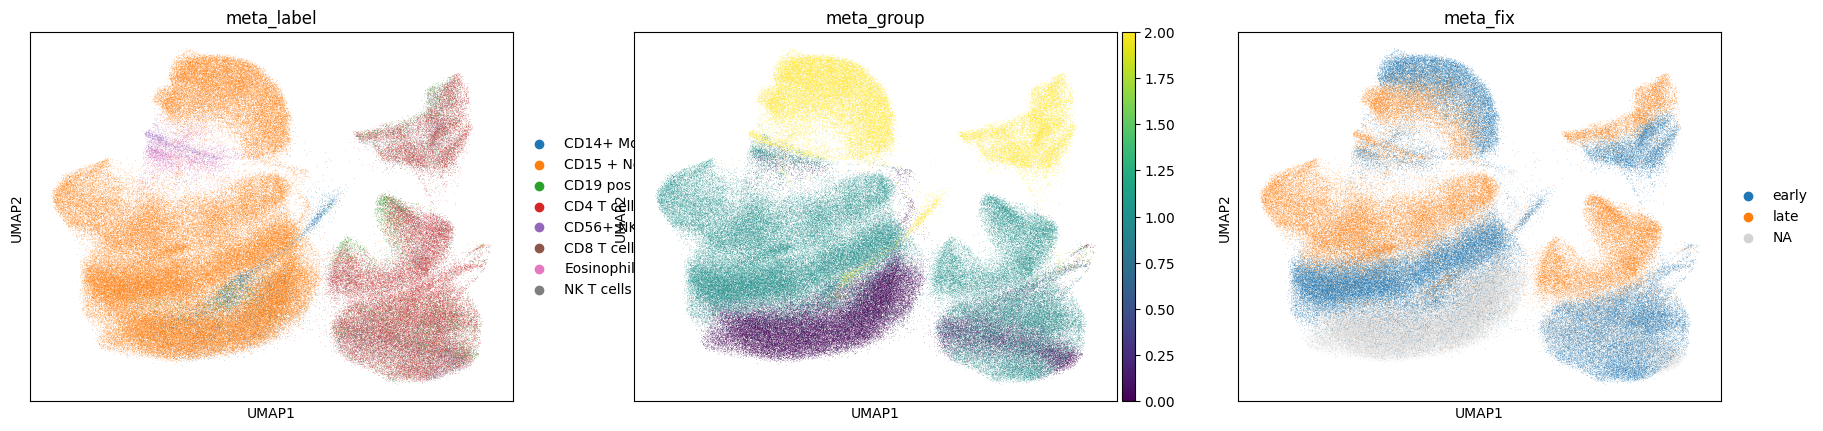

In [20]:
scanpy.pl.umap(adata, color=["meta_label", "meta_group", "meta_fix"])

In [52]:
from sklearn.model_selection import PredefinedSplit
from scip.features import intensity, shape
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer

test_fold_outer = df.index.to_frame().apply(
    lambda x: 0 if (x["meta_group"] == 2) and (x["meta_fix"] == "early") else -1,
    axis="columns"
).values 
outer_cv = PredefinedSplit(test_fold_outer)

X = df.filter(regex=".*_li_.*(BF1|BF2|SSC)$")
y = enc.transform(df["meta_label"])
outer_train, _ = next(outer_cv.split(X, y))
X = X.iloc[outer_train]
y = y[outer_train]

batch = adata.obs["meta_batch"].iloc[outer_train].cat.remove_unused_categories()

In [67]:
transformer = make_column_transformer(
    (
        RobustScaler(quantile_range=(5,95)),
        make_column_selector(
            pattern=".*(glcm|sobel|%s).*" % "|".join(intensity.props)
        )
    ),
    (
        MinMaxScaler(), 
        make_column_selector(
            pattern=".*(%s).*" % "|".join(shape.prop_names)
        )
    ), 
    remainder="passthrough"
).set_output(transform="pandas")

In [116]:
X_scaled = X.groupby(batch.values).apply(lambda gdf: transformer.fit_transform(gdf))
adata = anndata.AnnData(
    X = X_scaled.reset_index(drop=True),
    obs = df.filter(regex="meta").iloc[outer_train].reset_index()
)

/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1123: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1123: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1123: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/sklea

/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


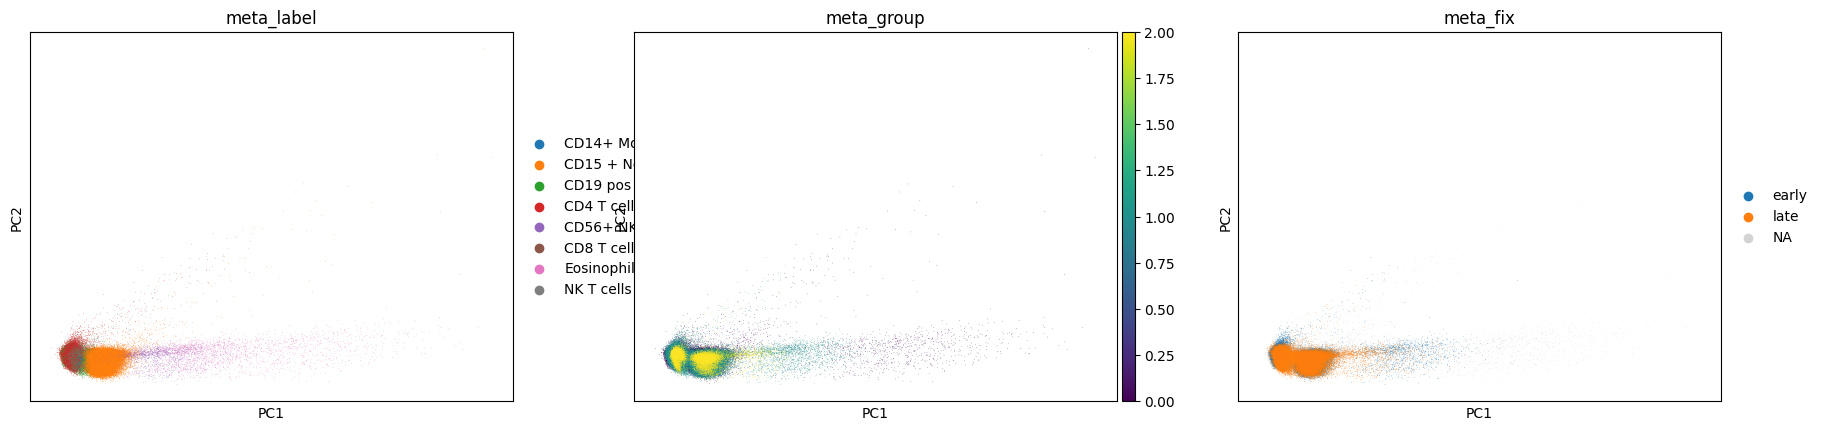

In [117]:
scanpy.pp.pca(adata)
scanpy.pl.pca(adata, color=["meta_label", "meta_group", "meta_fix"])

In [118]:
scanpy.pp.neighbors(adata)
scanpy.tl.umap(adata)

/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/srv/scratch/maximl/mambaforge/envs/scip2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


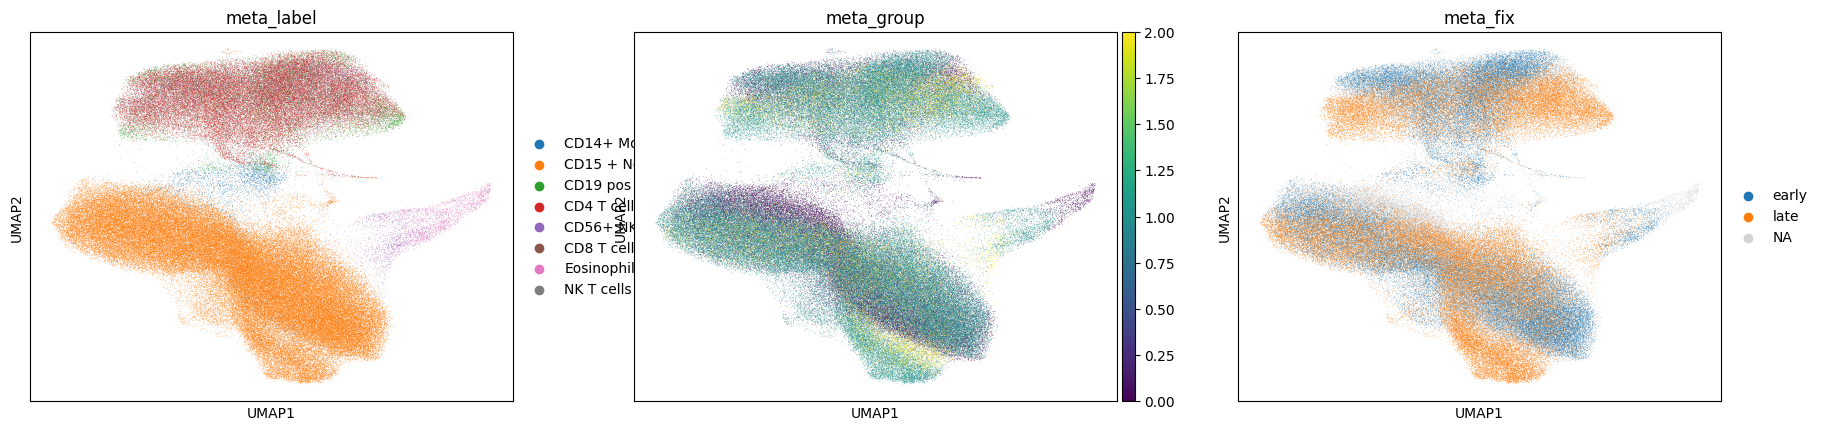

In [119]:
scanpy.pl.umap(adata, color=["meta_label", "meta_group", "meta_fix"])